# Estimation of mass of catalyst required from the data read from Aspen Simulation 

In [1]:
# 20/02/2023

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import os
import win32com.client as win32

In [3]:
""" ACCESSING ASPEN PLUS THROUGH COM """
aspen_v2 = win32.Dispatch("apwn.Document")

""" Specify the path of ASPEN PLUS BACKUP FILE TO BE ACCESSED HERE """
aspen_v2.InitFromArchive2(os.path.abspath('\\Users\\sirigina\\OneDrive - KTH\\Aspen\\Aspen sim files\\MGM-NEGAF_v2_file for Emma data.bkp'))

In [4]:
print(dir(aspen_v2))

['_ApplyTypes_', '_FlagAsMethod', '_LazyAddAttr_', '_NewEnum', '_Release_', '__AttrToID__', '__LazyMap__', '__bool__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__int__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_builtMethods_', '_enum_', '_find_dispatch_type_', '_get_good_object_', '_get_good_single_object_', '_lazydata_', '_make_method_', '_mapCachedItems_', '_oleobj_', '_olerepr_', '_print_details_', '_proc_', '_unicode_to_string_', '_username_', '_wrap_dispatch_']


In [5]:
""" Reading data from ASPEN Plus Simulation """

aspen_v2.Engine.Run2()
if aspen_v2.Tree.FindNode("\Data\Results Summary\Run-Status\Output\PER_ERROR").Dimension == 1:
    for element in aspen_v2.Tree.FindNode("\Data\Results Summary\Run-Status\Output\PER_ERROR").Elements:
        print(element.Value)
    print("\n")

#Inlet feed flow rate (l/min)     
#inlet_feed_flowrate = aspen_v2.Tree.FindNode("\Data\Blocks\BLO\Stream Results\Table\Total Flow l/min BLO-I").Value
#print("inlet total volumetric flow rate is {} l/min".format(inlet_feed_flowrate))

#CH4 feed molar flow rate to the reactor (mol/s)
inlet_ch4_feed_molar_flowrate = (aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\MOLEFLOW\MIXED\CH4").Value)*1000
print("inlet_ch4_feed_molar_flowrate is {}".format(inlet_ch4_feed_molar_flowrate))

# Inlet total pressure to the reactor (Pa or N/sqm)
inlet_total_pressure = aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\PRES_OUT\MIXED").Value
print("inlet_total_pressure is {}".format(inlet_total_pressure))

# Inlet CH4 mole fraction to the reactor (-)
inlet_CH4_frac = aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\MOLEFRAC\MIXED\CH4").Value
print("inlet_CH4_frac is {}".format(inlet_CH4_frac))

# Inlet partial pressure of H2O (Pa or N/sqm)
inlet_h2o_partial_pressure = aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\MOLEFRAC\MIXED\H2O").Value*inlet_total_pressure
print("inlet_h2o_partial_pressure is {}".format(inlet_h2o_partial_pressure))

# Inlet partial pressure of CH4 (Pa or N/sqm)
inlet_ch4_partial_pressure = inlet_CH4_frac*inlet_total_pressure
print("inlet_ch4_partial_pressure is {}".format(inlet_ch4_partial_pressure))

# Alpha of H2O - defined as the ratio of inlet partial pressure of H2O to inlet partial pressure of CH4
alpha_h2o = inlet_h2o_partial_pressure/inlet_ch4_partial_pressure
print("alpha_h2o is {}".format(alpha_h2o))




The following messages were issued during Input Translation:

   INFORMATION
   THERE ARE HENRY COMPONENTS DEFINED IN THIS CASE, THE BINARY DATABANK
   WILL BE SEARCHED AUTOMATICALLY FOR ANY AVAILABLE HENRY CONSTANTS.


inlet_ch4_feed_molar_flowrate is 0.0242990633
inlet_total_pressure is 116900.737
inlet_CH4_frac is 0.00301422212
inlet_h2o_partial_pressure is 637.0351225251349
inlet_ch4_partial_pressure is 352.3647873097024
alpha_h2o is 1.807885309394518


In [6]:
""" Kinetic equation for steady state conversion of methane in a fixed bed reactor at the given temperatures
    T = Temperature at which the reaction is happening (C)
    F0 = Initial flow rate of gas feed (including Oxygen, and other inert gases)
    y0_CH4 = Mole fraction of methane in feed flow (Same as volume fraction under ideal gas assumption) 
    RH = Relative humidity in fraction"""
def model(x_CH4,W, T, F0_CH4, y0_CH4, alpha, P0):
    
    
    """Internal effectiveness factor"""
    int_eff_factor_dict = {300: 0.47, 330: 0.36, 350: 0.3, 380: 0.24}
    int_eff_factor = int_eff_factor_dict[T]
    
    """ Rate constant (mol.g_Cat.mol_site-2.Pa-1.s-1)"""
    k_s_dict = {300 : 7.2, 330: 13.5, 350: 19.9, 380: 0.24}
    k_s = k_s_dict[T] # Rate constant 
    
    """Water adsoprtion equilibrium constant (Pa-1)"""
    K_H20_dict = {300: 1.25*10**-2, 330: 5.32*10**-3, 350: 3.16*10**-3, 380: 1.53*10**-3}
    K_H20 = K_H20_dict[T]
    
    """Total sites per gram of catalyst (mol_site.g_cat-1)"""
    C_T = 2.04 * (10**-4)
    
    """Total pressure"""
    P0 = P0
    
    """Ratio of partial pressure of H2O to CH4 at the inlet of the reactor"""
    alpha_H20 = alpha
    
    
    dx_CH4dW = (int_eff_factor*k_s*(C_T**2)*P0*(1-x_CH4)*y0_CH4)/((1+ (K_H20*P0*(alpha_H20+2*x_CH4)*y0_CH4) ) * F0_CH4)
    return dx_CH4dW

For the conversion [0.], the mass of catalyst is 0.0 g
For the conversion [17.97480894], the mass of catalyst is 320.03200320032005 g
For the conversion [31.24432208], the mass of catalyst is 640.0640064006401 g
For the conversion [41.58401714], the mass of catalyst is 960.0960096009601 g
For the conversion [49.90509812], the mass of catalyst is 1280.1280128012802 g
For the conversion [56.74717514], the mass of catalyst is 1600.1600160016003 g
For the conversion [62.4599485], the mass of catalyst is 1920.1920192019202 g
For the conversion [67.2846073], the mass of catalyst is 2240.2240224022403 g
For the conversion [71.39526374], the mass of catalyst is 2560.2560256025604 g
For the conversion [74.92205711], the mass of catalyst is 2880.2880288028805 g
For the conversion [77.96495045], the mass of catalyst is 3200.3200320032006 g
For the conversion [80.60243213], the mass of catalyst is 3520.3520352035207 g
For the conversion [82.89724309], the mass of catalyst is 3840.3840384038403 g
F

For the conversion [99.99999961], the mass of catalyst is 52805.280528052805 g
For the conversion [99.99999965], the mass of catalyst is 53125.31253125313 g
For the conversion [99.99999969], the mass of catalyst is 53445.34453445345 g
For the conversion [99.99999972], the mass of catalyst is 53765.37653765377 g
For the conversion [99.99999975], the mass of catalyst is 54085.408540854085 g
For the conversion [99.99999977], the mass of catalyst is 54405.44054405441 g
For the conversion [99.9999998], the mass of catalyst is 54725.47254725473 g
For the conversion [99.99999982], the mass of catalyst is 55045.50455045505 g
For the conversion [99.99999984], the mass of catalyst is 55365.536553655365 g
For the conversion [99.99999986], the mass of catalyst is 55685.56855685569 g
For the conversion [99.99999987], the mass of catalyst is 56005.60056005601 g
For the conversion [99.99999988], the mass of catalyst is 56325.63256325633 g
For the conversion [99.9999999], the mass of catalyst is 56645

For the conversion [100.00000001], the mass of catalyst is 104010.40104010401 g
For the conversion [100.00000001], the mass of catalyst is 104330.43304330434 g
For the conversion [100.00000001], the mass of catalyst is 104650.46504650466 g
For the conversion [100.00000001], the mass of catalyst is 104970.49704970498 g
For the conversion [100.00000001], the mass of catalyst is 105290.5290529053 g
For the conversion [100.00000001], the mass of catalyst is 105610.56105610561 g
For the conversion [100.00000001], the mass of catalyst is 105930.59305930593 g
For the conversion [100.00000001], the mass of catalyst is 106250.62506250625 g
For the conversion [100.00000001], the mass of catalyst is 106570.65706570657 g
For the conversion [100.00000001], the mass of catalyst is 106890.6890689069 g
For the conversion [100.00000001], the mass of catalyst is 107210.72107210722 g
For the conversion [100.00000001], the mass of catalyst is 107530.75307530754 g
For the conversion [100.00000001], the mas

For the conversion [100.], the mass of catalyst is 149134.91349134914 g
For the conversion [100.], the mass of catalyst is 149454.94549454947 g
For the conversion [100.], the mass of catalyst is 149774.9774977498 g
For the conversion [100.], the mass of catalyst is 150095.0095009501 g
For the conversion [100.], the mass of catalyst is 150415.04150415043 g
For the conversion [100.], the mass of catalyst is 150735.07350735075 g
For the conversion [100.], the mass of catalyst is 151055.10551055107 g
For the conversion [100.], the mass of catalyst is 151375.1375137514 g
For the conversion [100.], the mass of catalyst is 151695.1695169517 g
For the conversion [100.], the mass of catalyst is 152015.201520152 g
For the conversion [100.], the mass of catalyst is 152335.23352335233 g
For the conversion [100.], the mass of catalyst is 152655.26552655266 g
For the conversion [100.], the mass of catalyst is 152975.29752975298 g
For the conversion [100.], the mass of catalyst is 153295.3295329533 g

For the conversion [100.], the mass of catalyst is 193299.3299329933 g
For the conversion [100.], the mass of catalyst is 193619.36193619363 g
For the conversion [100.], the mass of catalyst is 193939.39393939395 g
For the conversion [100.], the mass of catalyst is 194259.42594259427 g
For the conversion [100.], the mass of catalyst is 194579.4579457946 g
For the conversion [100.], the mass of catalyst is 194899.48994899492 g
For the conversion [100.], the mass of catalyst is 195219.52195219524 g
For the conversion [100.], the mass of catalyst is 195539.55395539556 g
For the conversion [100.], the mass of catalyst is 195859.58595859588 g
For the conversion [100.], the mass of catalyst is 196179.61796179618 g
For the conversion [100.], the mass of catalyst is 196499.6499649965 g
For the conversion [100.], the mass of catalyst is 196819.68196819682 g
For the conversion [100.], the mass of catalyst is 197139.71397139714 g
For the conversion [100.], the mass of catalyst is 197459.745974597

For the conversion [100.], the mass of catalyst is 264666.46664666466 g
For the conversion [100.], the mass of catalyst is 264986.498649865 g
For the conversion [100.], the mass of catalyst is 265306.5306530653 g
For the conversion [100.], the mass of catalyst is 265626.5626562656 g
For the conversion [100.], the mass of catalyst is 265946.59465946595 g
For the conversion [100.], the mass of catalyst is 266266.62666266627 g
For the conversion [100.], the mass of catalyst is 266586.6586658666 g
For the conversion [100.], the mass of catalyst is 266906.6906690669 g
For the conversion [100.], the mass of catalyst is 267226.72267226723 g
For the conversion [100.], the mass of catalyst is 267546.75467546756 g
For the conversion [100.], the mass of catalyst is 267866.7866786679 g
For the conversion [100.], the mass of catalyst is 268186.8186818682 g
For the conversion [100.], the mass of catalyst is 268506.8506850685 g
For the conversion [100.], the mass of catalyst is 268826.88268826884 g
F

For the conversion [100.], the mass of catalyst is 318431.84318431845 g
For the conversion [100.], the mass of catalyst is 318751.8751875188 g
For the conversion [100.], the mass of catalyst is 319071.9071907191 g
For the conversion [100.], the mass of catalyst is 319391.9391939194 g
For the conversion [100.], the mass of catalyst is 319711.97119711974 g
For the conversion [100.], the mass of catalyst is 320032.00320032006 g
For the conversion [100.], the mass of catalyst is 320352.0352035204 g
For the conversion [100.], the mass of catalyst is 320672.0672067207 g
For the conversion [100.], the mass of catalyst is 320992.099209921 g
For the conversion [100.], the mass of catalyst is 321312.13121312135 g
For the conversion [100.], the mass of catalyst is 321632.1632163217 g
For the conversion [100.], the mass of catalyst is 321952.195219522 g
For the conversion [100.], the mass of catalyst is 322272.2272227223 g
For the conversion [100.], the mass of catalyst is 322592.25922592264 g
For

For the conversion [100.], the mass of catalyst is 377637.76377637766 g
For the conversion [100.], the mass of catalyst is 377957.795779578 g
For the conversion [100.], the mass of catalyst is 378277.8277827783 g
For the conversion [100.], the mass of catalyst is 378597.8597859786 g
For the conversion [100.], the mass of catalyst is 378917.89178917895 g
For the conversion [100.], the mass of catalyst is 379237.92379237927 g
For the conversion [100.], the mass of catalyst is 379557.9557955796 g
For the conversion [100.], the mass of catalyst is 379877.9877987799 g
For the conversion [100.], the mass of catalyst is 380198.01980198023 g
For the conversion [100.], the mass of catalyst is 380518.05180518056 g
For the conversion [100.], the mass of catalyst is 380838.0838083809 g
For the conversion [100.], the mass of catalyst is 381158.1158115812 g
For the conversion [100.], the mass of catalyst is 381478.1478147815 g
For the conversion [100.], the mass of catalyst is 381798.17981798184 g
F

For the conversion [100.], the mass of catalyst is 464686.4686468647 g
For the conversion [100.], the mass of catalyst is 465006.500650065 g
For the conversion [100.], the mass of catalyst is 465326.53265326534 g
For the conversion [100.], the mass of catalyst is 465646.56465646566 g
For the conversion [100.], the mass of catalyst is 465966.596659666 g
For the conversion [100.], the mass of catalyst is 466286.6286628663 g
For the conversion [100.], the mass of catalyst is 466606.66066606663 g
For the conversion [100.], the mass of catalyst is 466926.69266926695 g
For the conversion [100.], the mass of catalyst is 467246.7246724673 g
For the conversion [100.], the mass of catalyst is 467566.7566756676 g
For the conversion [100.], the mass of catalyst is 467886.7886788679 g
For the conversion [100.], the mass of catalyst is 468206.82068206824 g
For the conversion [100.], the mass of catalyst is 468526.85268526856 g
For the conversion [100.], the mass of catalyst is 468846.8846884689 g
Fo

For the conversion [100.], the mass of catalyst is 523892.3892389239 g
For the conversion [100.], the mass of catalyst is 524212.4212421242 g
For the conversion [100.], the mass of catalyst is 524532.4532453245 g
For the conversion [100.], the mass of catalyst is 524852.4852485249 g
For the conversion [100.], the mass of catalyst is 525172.5172517252 g
For the conversion [100.], the mass of catalyst is 525492.5492549256 g
For the conversion [100.], the mass of catalyst is 525812.5812581258 g
For the conversion [100.], the mass of catalyst is 526132.6132613262 g
For the conversion [100.], the mass of catalyst is 526452.6452645265 g
For the conversion [100.], the mass of catalyst is 526772.6772677267 g
For the conversion [100.], the mass of catalyst is 527092.7092709271 g
For the conversion [100.], the mass of catalyst is 527412.7412741274 g
For the conversion [100.], the mass of catalyst is 527732.7732773278 g
For the conversion [100.], the mass of catalyst is 528052.805280528 g
For the

For the conversion [100.], the mass of catalyst is 573177.3177317732 g
For the conversion [100.], the mass of catalyst is 573497.3497349735 g
For the conversion [100.], the mass of catalyst is 573817.3817381739 g
For the conversion [100.], the mass of catalyst is 574137.4137413742 g
For the conversion [100.], the mass of catalyst is 574457.4457445745 g
For the conversion [100.], the mass of catalyst is 574777.4777477748 g
For the conversion [100.], the mass of catalyst is 575097.5097509752 g
For the conversion [100.], the mass of catalyst is 575417.5417541754 g
For the conversion [100.], the mass of catalyst is 575737.5737573758 g
For the conversion [100.], the mass of catalyst is 576057.6057605761 g
For the conversion [100.], the mass of catalyst is 576377.6377637764 g
For the conversion [100.], the mass of catalyst is 576697.6697669767 g
For the conversion [100.], the mass of catalyst is 577017.701770177 g
For the conversion [100.], the mass of catalyst is 577337.7337733774 g
For the

For the conversion [100.], the mass of catalyst is 694149.4149414942 g
For the conversion [100.], the mass of catalyst is 694469.4469446945 g
For the conversion [100.], the mass of catalyst is 694789.4789478949 g
For the conversion [100.], the mass of catalyst is 695109.5109510951 g
For the conversion [100.], the mass of catalyst is 695429.5429542954 g
For the conversion [100.], the mass of catalyst is 695749.5749574958 g
For the conversion [100.], the mass of catalyst is 696069.606960696 g
For the conversion [100.], the mass of catalyst is 696389.6389638964 g
For the conversion [100.], the mass of catalyst is 696709.6709670967 g
For the conversion [100.], the mass of catalyst is 697029.7029702971 g
For the conversion [100.], the mass of catalyst is 697349.7349734973 g
For the conversion [100.], the mass of catalyst is 697669.7669766977 g
For the conversion [100.], the mass of catalyst is 697989.798979898 g
For the conversion [100.], the mass of catalyst is 698309.8309830984 g
For the 

For the conversion [100.], the mass of catalyst is 744394.4394439445 g
For the conversion [100.], the mass of catalyst is 744714.4714471448 g
For the conversion [100.], the mass of catalyst is 745034.503450345 g
For the conversion [100.], the mass of catalyst is 745354.5354535454 g
For the conversion [100.], the mass of catalyst is 745674.5674567457 g
For the conversion [100.], the mass of catalyst is 745994.599459946 g
For the conversion [100.], the mass of catalyst is 746314.6314631463 g
For the conversion [100.], the mass of catalyst is 746634.6634663467 g
For the conversion [100.], the mass of catalyst is 746954.695469547 g
For the conversion [100.], the mass of catalyst is 747274.7274727473 g
For the conversion [100.], the mass of catalyst is 747594.7594759476 g
For the conversion [100.], the mass of catalyst is 747914.791479148 g
For the conversion [100.], the mass of catalyst is 748234.8234823482 g
For the conversion [100.], the mass of catalyst is 748554.8554855486 g
For the co

For the conversion [100.], the mass of catalyst is 782798.2798279829 g
For the conversion [100.], the mass of catalyst is 783118.3118311831 g
For the conversion [100.], the mass of catalyst is 783438.3438343835 g
For the conversion [100.], the mass of catalyst is 783758.3758375838 g
For the conversion [100.], the mass of catalyst is 784078.4078407842 g
For the conversion [100.], the mass of catalyst is 784398.4398439844 g
For the conversion [100.], the mass of catalyst is 784718.4718471847 g
For the conversion [100.], the mass of catalyst is 785038.5038503851 g
For the conversion [100.], the mass of catalyst is 785358.5358535853 g
For the conversion [100.], the mass of catalyst is 785678.5678567857 g
For the conversion [100.], the mass of catalyst is 785998.599859986 g
For the conversion [100.], the mass of catalyst is 786318.6318631864 g
For the conversion [100.], the mass of catalyst is 786638.6638663866 g
For the conversion [100.], the mass of catalyst is 786958.695869587 g
For the 

For the conversion [100.], the mass of catalyst is 824402.4402440244 g
For the conversion [100.], the mass of catalyst is 824722.4722472248 g
For the conversion [100.], the mass of catalyst is 825042.504250425 g
For the conversion [100.], the mass of catalyst is 825362.5362536254 g
For the conversion [100.], the mass of catalyst is 825682.5682568257 g
For the conversion [100.], the mass of catalyst is 826002.600260026 g
For the conversion [100.], the mass of catalyst is 826322.6322632263 g
For the conversion [100.], the mass of catalyst is 826642.6642664267 g
For the conversion [100.], the mass of catalyst is 826962.696269627 g
For the conversion [100.], the mass of catalyst is 827282.7282728273 g
For the conversion [100.], the mass of catalyst is 827602.7602760276 g
For the conversion [100.], the mass of catalyst is 827922.792279228 g
For the conversion [100.], the mass of catalyst is 828242.8242824282 g
For the conversion [100.], the mass of catalyst is 828562.8562856286 g
For the co

For the conversion [100.], the mass of catalyst is 876887.688768877 g
For the conversion [100.], the mass of catalyst is 877207.7207720772 g
For the conversion [100.], the mass of catalyst is 877527.7527752776 g
For the conversion [100.], the mass of catalyst is 877847.7847784779 g
For the conversion [100.], the mass of catalyst is 878167.8167816782 g
For the conversion [100.], the mass of catalyst is 878487.8487848785 g
For the conversion [100.], the mass of catalyst is 878807.8807880789 g
For the conversion [100.], the mass of catalyst is 879127.9127912791 g
For the conversion [100.], the mass of catalyst is 879447.9447944795 g
For the conversion [100.], the mass of catalyst is 879767.9767976798 g
For the conversion [100.], the mass of catalyst is 880088.0088008802 g
For the conversion [100.], the mass of catalyst is 880408.0408040804 g
For the conversion [100.], the mass of catalyst is 880728.0728072808 g
For the conversion [100.], the mass of catalyst is 881048.1048104811 g
For the

For the conversion [100.], the mass of catalyst is 935133.5133513352 g
For the conversion [100.], the mass of catalyst is 935453.5453545355 g
For the conversion [100.], the mass of catalyst is 935773.5773577358 g
For the conversion [100.], the mass of catalyst is 936093.6093609361 g
For the conversion [100.], the mass of catalyst is 936413.6413641365 g
For the conversion [100.], the mass of catalyst is 936733.6733673367 g
For the conversion [100.], the mass of catalyst is 937053.7053705371 g
For the conversion [100.], the mass of catalyst is 937373.7373737374 g
For the conversion [100.], the mass of catalyst is 937693.7693769378 g
For the conversion [100.], the mass of catalyst is 938013.801380138 g
For the conversion [100.], the mass of catalyst is 938333.8333833384 g
For the conversion [100.], the mass of catalyst is 938653.8653865387 g
For the conversion [100.], the mass of catalyst is 938973.897389739 g
For the conversion [100.], the mass of catalyst is 939293.9293929393 g
For the 

For the conversion [100.], the mass of catalyst is 974177.4177417742 g
For the conversion [100.], the mass of catalyst is 974497.4497449745 g
For the conversion [100.], the mass of catalyst is 974817.4817481749 g
For the conversion [100.], the mass of catalyst is 975137.5137513751 g
For the conversion [100.], the mass of catalyst is 975457.5457545755 g
For the conversion [100.], the mass of catalyst is 975777.5777577758 g
For the conversion [100.], the mass of catalyst is 976097.6097609762 g
For the conversion [100.], the mass of catalyst is 976417.6417641764 g
For the conversion [100.], the mass of catalyst is 976737.6737673768 g
For the conversion [100.], the mass of catalyst is 977057.7057705771 g
For the conversion [100.], the mass of catalyst is 977377.7377737775 g
For the conversion [100.], the mass of catalyst is 977697.7697769777 g
For the conversion [100.], the mass of catalyst is 978017.8017801781 g
For the conversion [100.], the mass of catalyst is 978337.8337833784 g
For th

For the conversion [100.], the mass of catalyst is 1015141.5141514152 g
For the conversion [100.], the mass of catalyst is 1015461.5461546155 g
For the conversion [100.], the mass of catalyst is 1015781.5781578158 g
For the conversion [100.], the mass of catalyst is 1016101.6101610161 g
For the conversion [100.], the mass of catalyst is 1016421.6421642165 g
For the conversion [100.], the mass of catalyst is 1016741.6741674168 g
For the conversion [100.], the mass of catalyst is 1017061.7061706171 g
For the conversion [100.], the mass of catalyst is 1017381.7381738174 g
For the conversion [100.], the mass of catalyst is 1017701.7701770178 g
For the conversion [100.], the mass of catalyst is 1018021.802180218 g
For the conversion [100.], the mass of catalyst is 1018341.8341834184 g
For the conversion [100.], the mass of catalyst is 1018661.8661866187 g
For the conversion [100.], the mass of catalyst is 1018981.8981898191 g
For the conversion [100.], the mass of catalyst is 1019301.930193

For the conversion [100.], the mass of catalyst is 1082668.2668266827 g
For the conversion [100.], the mass of catalyst is 1082988.298829883 g
For the conversion [100.], the mass of catalyst is 1083308.3308330833 g
For the conversion [100.], the mass of catalyst is 1083628.3628362836 g
For the conversion [100.], the mass of catalyst is 1083948.394839484 g
For the conversion [100.], the mass of catalyst is 1084268.4268426844 g
For the conversion [100.], the mass of catalyst is 1084588.4588458845 g
For the conversion [100.], the mass of catalyst is 1084908.490849085 g
For the conversion [100.], the mass of catalyst is 1085228.5228522853 g
For the conversion [100.], the mass of catalyst is 1085548.5548554857 g
For the conversion [100.], the mass of catalyst is 1085868.5868586858 g
For the conversion [100.], the mass of catalyst is 1086188.6188618862 g
For the conversion [100.], the mass of catalyst is 1086508.6508650866 g
For the conversion [100.], the mass of catalyst is 1086828.68286828

For the conversion [100.], the mass of catalyst is 1120432.0432043206 g
For the conversion [100.], the mass of catalyst is 1120752.0752075207 g
For the conversion [100.], the mass of catalyst is 1121072.1072107211 g
For the conversion [100.], the mass of catalyst is 1121392.1392139215 g
For the conversion [100.], the mass of catalyst is 1121712.1712171219 g
For the conversion [100.], the mass of catalyst is 1122032.203220322 g
For the conversion [100.], the mass of catalyst is 1122352.2352235224 g
For the conversion [100.], the mass of catalyst is 1122672.2672267228 g
For the conversion [100.], the mass of catalyst is 1122992.299229923 g
For the conversion [100.], the mass of catalyst is 1123312.3312331233 g
For the conversion [100.], the mass of catalyst is 1123632.3632363237 g
For the conversion [100.], the mass of catalyst is 1123952.395239524 g
For the conversion [100.], the mass of catalyst is 1124272.4272427242 g
For the conversion [100.], the mass of catalyst is 1124592.45924592

For the conversion [100.], the mass of catalyst is 1188278.8278827884 g
For the conversion [100.], the mass of catalyst is 1188598.8598859888 g
For the conversion [100.], the mass of catalyst is 1188918.891889189 g
For the conversion [100.], the mass of catalyst is 1189238.9238923893 g
For the conversion [100.], the mass of catalyst is 1189558.9558955897 g
For the conversion [100.], the mass of catalyst is 1189878.98789879 g
For the conversion [100.], the mass of catalyst is 1190199.0199019902 g
For the conversion [100.], the mass of catalyst is 1190519.0519051906 g
For the conversion [100.], the mass of catalyst is 1190839.083908391 g
For the conversion [100.], the mass of catalyst is 1191159.1159115913 g
For the conversion [100.], the mass of catalyst is 1191479.1479147915 g
For the conversion [100.], the mass of catalyst is 1191799.1799179919 g
For the conversion [100.], the mass of catalyst is 1192119.2119211922 g
For the conversion [100.], the mass of catalyst is 1192439.243924392

For the conversion [100.], the mass of catalyst is 1234043.4043404341 g
For the conversion [100.], the mass of catalyst is 1234363.4363436345 g
For the conversion [100.], the mass of catalyst is 1234683.4683468346 g
For the conversion [100.], the mass of catalyst is 1235003.500350035 g
For the conversion [100.], the mass of catalyst is 1235323.5323532354 g
For the conversion [100.], the mass of catalyst is 1235643.5643564358 g
For the conversion [100.], the mass of catalyst is 1235963.596359636 g
For the conversion [100.], the mass of catalyst is 1236283.6283628363 g
For the conversion [100.], the mass of catalyst is 1236603.6603660367 g
For the conversion [100.], the mass of catalyst is 1236923.692369237 g
For the conversion [100.], the mass of catalyst is 1237243.7243724372 g
For the conversion [100.], the mass of catalyst is 1237563.7563756376 g
For the conversion [100.], the mass of catalyst is 1237883.788378838 g
For the conversion [100.], the mass of catalyst is 1238203.820382038

For the conversion [100.], the mass of catalyst is 1282688.2688268828 g
For the conversion [100.], the mass of catalyst is 1283008.300830083 g
For the conversion [100.], the mass of catalyst is 1283328.3328332833 g
For the conversion [100.], the mass of catalyst is 1283648.3648364837 g
For the conversion [100.], the mass of catalyst is 1283968.396839684 g
For the conversion [100.], the mass of catalyst is 1284288.4288428843 g
For the conversion [100.], the mass of catalyst is 1284608.4608460846 g
For the conversion [100.], the mass of catalyst is 1284928.492849285 g
For the conversion [100.], the mass of catalyst is 1285248.5248524854 g
For the conversion [100.], the mass of catalyst is 1285568.5568556855 g
For the conversion [100.], the mass of catalyst is 1285888.588858886 g
For the conversion [100.], the mass of catalyst is 1286208.6208620863 g
For the conversion [100.], the mass of catalyst is 1286528.6528652867 g
For the conversion [100.], the mass of catalyst is 1286848.684868486

For the conversion [100.], the mass of catalyst is 1376777.677767777 g
For the conversion [100.], the mass of catalyst is 1377097.7097709773 g
For the conversion [100.], the mass of catalyst is 1377417.7417741774 g
For the conversion [100.], the mass of catalyst is 1377737.7737773778 g
For the conversion [100.], the mass of catalyst is 1378057.8057805782 g
For the conversion [100.], the mass of catalyst is 1378377.8377837786 g
For the conversion [100.], the mass of catalyst is 1378697.8697869787 g
For the conversion [100.], the mass of catalyst is 1379017.901790179 g
For the conversion [100.], the mass of catalyst is 1379337.9337933795 g
For the conversion [100.], the mass of catalyst is 1379657.9657965798 g
For the conversion [100.], the mass of catalyst is 1379977.99779978 g
For the conversion [100.], the mass of catalyst is 1380298.0298029804 g
For the conversion [100.], the mass of catalyst is 1380618.0618061807 g
For the conversion [100.], the mass of catalyst is 1380938.093809381

For the conversion [100.], the mass of catalyst is 1428302.8302830283 g
For the conversion [100.], the mass of catalyst is 1428622.8622862287 g
For the conversion [100.], the mass of catalyst is 1428942.894289429 g
For the conversion [100.], the mass of catalyst is 1429262.9262926294 g
For the conversion [100.], the mass of catalyst is 1429582.9582958296 g
For the conversion [100.], the mass of catalyst is 1429902.99029903 g
For the conversion [100.], the mass of catalyst is 1430223.0223022304 g
For the conversion [100.], the mass of catalyst is 1430543.0543054305 g
For the conversion [100.], the mass of catalyst is 1430863.0863086309 g
For the conversion [100.], the mass of catalyst is 1431183.1183118313 g
For the conversion [100.], the mass of catalyst is 1431503.1503150316 g
For the conversion [100.], the mass of catalyst is 1431823.1823182318 g
For the conversion [100.], the mass of catalyst is 1432143.2143214322 g
For the conversion [100.], the mass of catalyst is 1432463.24632463

For the conversion [100.], the mass of catalyst is 1479187.9187918792 g
For the conversion [100.], the mass of catalyst is 1479507.9507950796 g
For the conversion [100.], the mass of catalyst is 1479827.98279828 g
For the conversion [100.], the mass of catalyst is 1480148.01480148 g
For the conversion [100.], the mass of catalyst is 1480468.0468046805 g
For the conversion [100.], the mass of catalyst is 1480788.0788078809 g
For the conversion [100.], the mass of catalyst is 1481108.1108110812 g
For the conversion [100.], the mass of catalyst is 1481428.1428142814 g
For the conversion [100.], the mass of catalyst is 1481748.1748174818 g
For the conversion [100.], the mass of catalyst is 1482068.2068206822 g
For the conversion [100.], the mass of catalyst is 1482388.2388238825 g
For the conversion [100.], the mass of catalyst is 1482708.2708270827 g
For the conversion [100.], the mass of catalyst is 1483028.302830283 g
For the conversion [100.], the mass of catalyst is 1483348.3348334834

For the conversion [100.], the mass of catalyst is 1518871.887188719 g
For the conversion [100.], the mass of catalyst is 1519191.9191919193 g
For the conversion [100.], the mass of catalyst is 1519511.9511951196 g
For the conversion [100.], the mass of catalyst is 1519831.9831983198 g
For the conversion [100.], the mass of catalyst is 1520152.0152015202 g
For the conversion [100.], the mass of catalyst is 1520472.0472047206 g
For the conversion [100.], the mass of catalyst is 1520792.079207921 g
For the conversion [100.], the mass of catalyst is 1521112.111211121 g
For the conversion [100.], the mass of catalyst is 1521432.1432143215 g
For the conversion [100.], the mass of catalyst is 1521752.1752175218 g
For the conversion [100.], the mass of catalyst is 1522072.2072207222 g
For the conversion [100.], the mass of catalyst is 1522392.2392239224 g
For the conversion [100.], the mass of catalyst is 1522712.2712271228 g
For the conversion [100.], the mass of catalyst is 1523032.30323032

For the conversion [100.], the mass of catalyst is 1563676.3676367637 g
For the conversion [100.], the mass of catalyst is 1563996.399639964 g
For the conversion [100.], the mass of catalyst is 1564316.4316431645 g
For the conversion [100.], the mass of catalyst is 1564636.4636463646 g
For the conversion [100.], the mass of catalyst is 1564956.495649565 g
For the conversion [100.], the mass of catalyst is 1565276.5276527654 g
For the conversion [100.], the mass of catalyst is 1565596.5596559658 g
For the conversion [100.], the mass of catalyst is 1565916.591659166 g
For the conversion [100.], the mass of catalyst is 1566236.6236623663 g
For the conversion [100.], the mass of catalyst is 1566556.6556655667 g
For the conversion [100.], the mass of catalyst is 1566876.687668767 g
For the conversion [100.], the mass of catalyst is 1567196.7196719672 g
For the conversion [100.], the mass of catalyst is 1567516.7516751676 g
For the conversion [100.], the mass of catalyst is 1567836.783678368

For the conversion [100.], the mass of catalyst is 1616481.6481648167 g
For the conversion [100.], the mass of catalyst is 1616801.6801680168 g
For the conversion [100.], the mass of catalyst is 1617121.7121712172 g
For the conversion [100.], the mass of catalyst is 1617441.7441744176 g
For the conversion [100.], the mass of catalyst is 1617761.776177618 g
For the conversion [100.], the mass of catalyst is 1618081.808180818 g
For the conversion [100.], the mass of catalyst is 1618401.8401840185 g
For the conversion [100.], the mass of catalyst is 1618721.8721872189 g
For the conversion [100.], the mass of catalyst is 1619041.904190419 g
For the conversion [100.], the mass of catalyst is 1619361.9361936194 g
For the conversion [100.], the mass of catalyst is 1619681.9681968198 g
For the conversion [100.], the mass of catalyst is 1620002.0002000201 g
For the conversion [100.], the mass of catalyst is 1620322.0322032203 g
For the conversion [100.], the mass of catalyst is 1620642.06420642

For the conversion [100.], the mass of catalyst is 1684968.496849685 g
For the conversion [100.], the mass of catalyst is 1685288.5288528854 g
For the conversion [100.], the mass of catalyst is 1685608.5608560857 g
For the conversion [100.], the mass of catalyst is 1685928.5928592861 g
For the conversion [100.], the mass of catalyst is 1686248.6248624863 g
For the conversion [100.], the mass of catalyst is 1686568.6568656866 g
For the conversion [100.], the mass of catalyst is 1686888.688868887 g
For the conversion [100.], the mass of catalyst is 1687208.7208720874 g
For the conversion [100.], the mass of catalyst is 1687528.7528752876 g
For the conversion [100.], the mass of catalyst is 1687848.784878488 g
For the conversion [100.], the mass of catalyst is 1688168.8168816883 g
For the conversion [100.], the mass of catalyst is 1688488.8488848885 g
For the conversion [100.], the mass of catalyst is 1688808.8808880888 g
For the conversion [100.], the mass of catalyst is 1689128.91289128

For the conversion [100.], the mass of catalyst is 1751855.1855185519 g
For the conversion [100.], the mass of catalyst is 1752175.2175217522 g
For the conversion [100.], the mass of catalyst is 1752495.2495249526 g
For the conversion [100.], the mass of catalyst is 1752815.281528153 g
For the conversion [100.], the mass of catalyst is 1753135.3135313531 g
For the conversion [100.], the mass of catalyst is 1753455.3455345535 g
For the conversion [100.], the mass of catalyst is 1753775.377537754 g
For the conversion [100.], the mass of catalyst is 1754095.4095409543 g
For the conversion [100.], the mass of catalyst is 1754415.4415441544 g
For the conversion [100.], the mass of catalyst is 1754735.4735473548 g
For the conversion [100.], the mass of catalyst is 1755055.5055505552 g
For the conversion [100.], the mass of catalyst is 1755375.5375537556 g
For the conversion [100.], the mass of catalyst is 1755695.5695569557 g
For the conversion [100.], the mass of catalyst is 1756015.6015601

For the conversion [100.], the mass of catalyst is 1817461.7461746174 g
For the conversion [100.], the mass of catalyst is 1817781.7781778178 g
For the conversion [100.], the mass of catalyst is 1818101.8101810182 g
For the conversion [100.], the mass of catalyst is 1818421.8421842186 g
For the conversion [100.], the mass of catalyst is 1818741.8741874187 g
For the conversion [100.], the mass of catalyst is 1819061.906190619 g
For the conversion [100.], the mass of catalyst is 1819381.9381938195 g
For the conversion [100.], the mass of catalyst is 1819701.9701970199 g
For the conversion [100.], the mass of catalyst is 1820022.00220022 g
For the conversion [100.], the mass of catalyst is 1820342.0342034204 g
For the conversion [100.], the mass of catalyst is 1820662.0662066208 g
For the conversion [100.], the mass of catalyst is 1820982.0982098212 g
For the conversion [100.], the mass of catalyst is 1821302.1302130213 g
For the conversion [100.], the mass of catalyst is 1821622.16221622

For the conversion [100.], the mass of catalyst is 1888508.8508850886 g
For the conversion [100.], the mass of catalyst is 1888828.882888289 g
For the conversion [100.], the mass of catalyst is 1889148.9148914893 g
For the conversion [100.], the mass of catalyst is 1889468.9468946895 g
For the conversion [100.], the mass of catalyst is 1889788.9788978898 g
For the conversion [100.], the mass of catalyst is 1890109.0109010902 g
For the conversion [100.], the mass of catalyst is 1890429.0429042906 g
For the conversion [100.], the mass of catalyst is 1890749.0749074908 g
For the conversion [100.], the mass of catalyst is 1891069.1069106911 g
For the conversion [100.], the mass of catalyst is 1891389.1389138915 g
For the conversion [100.], the mass of catalyst is 1891709.170917092 g
For the conversion [100.], the mass of catalyst is 1892029.202920292 g
For the conversion [100.], the mass of catalyst is 1892349.2349234924 g
For the conversion [100.], the mass of catalyst is 1892669.26692669

For the conversion [100.], the mass of catalyst is 1955075.5075507553 g
For the conversion [100.], the mass of catalyst is 1955395.5395539554 g
For the conversion [100.], the mass of catalyst is 1955715.5715571558 g
For the conversion [100.], the mass of catalyst is 1956035.6035603562 g
For the conversion [100.], the mass of catalyst is 1956355.6355635563 g
For the conversion [100.], the mass of catalyst is 1956675.6675667567 g
For the conversion [100.], the mass of catalyst is 1956995.699569957 g
For the conversion [100.], the mass of catalyst is 1957315.7315731575 g
For the conversion [100.], the mass of catalyst is 1957635.7635763576 g
For the conversion [100.], the mass of catalyst is 1957955.795579558 g
For the conversion [100.], the mass of catalyst is 1958275.8275827584 g
For the conversion [100.], the mass of catalyst is 1958595.8595859588 g
For the conversion [100.], the mass of catalyst is 1958915.891589159 g
For the conversion [100.], the mass of catalyst is 1959235.92359235

For the conversion [100.], the mass of catalyst is 2031243.1243124313 g
For the conversion [100.], the mass of catalyst is 2031563.1563156317 g
For the conversion [100.], the mass of catalyst is 2031883.188318832 g
For the conversion [100.], the mass of catalyst is 2032203.2203220322 g
For the conversion [100.], the mass of catalyst is 2032523.2523252326 g
For the conversion [100.], the mass of catalyst is 2032843.284328433 g
For the conversion [100.], the mass of catalyst is 2033163.3163316334 g
For the conversion [100.], the mass of catalyst is 2033483.3483348335 g
For the conversion [100.], the mass of catalyst is 2033803.380338034 g
For the conversion [100.], the mass of catalyst is 2034123.4123412343 g
For the conversion [100.], the mass of catalyst is 2034443.4443444347 g
For the conversion [100.], the mass of catalyst is 2034763.4763476348 g
For the conversion [100.], the mass of catalyst is 2035083.5083508352 g
For the conversion [100.], the mass of catalyst is 2035403.54035403

For the conversion [100.], the mass of catalyst is 2096529.6529652965 g
For the conversion [100.], the mass of catalyst is 2096849.684968497 g
For the conversion [100.], the mass of catalyst is 2097169.7169716973 g
For the conversion [100.], the mass of catalyst is 2097489.7489748974 g
For the conversion [100.], the mass of catalyst is 2097809.780978098 g
For the conversion [100.], the mass of catalyst is 2098129.812981298 g
For the conversion [100.], the mass of catalyst is 2098449.8449844983 g
For the conversion [100.], the mass of catalyst is 2098769.876987699 g
For the conversion [100.], the mass of catalyst is 2099089.908990899 g
For the conversion [100.], the mass of catalyst is 2099409.9409940997 g
For the conversion [100.], the mass of catalyst is 2099729.9729973 g
For the conversion [100.], the mass of catalyst is 2100050.0050005 g
For the conversion [100.], the mass of catalyst is 2100370.0370037006 g
For the conversion [100.], the mass of catalyst is 2100690.069006901 g
For 

For the conversion [100.], the mass of catalyst is 2142294.2294229423 g
For the conversion [100.], the mass of catalyst is 2142614.261426143 g
For the conversion [100.], the mass of catalyst is 2142934.293429343 g
For the conversion [100.], the mass of catalyst is 2143254.325432543 g
For the conversion [100.], the mass of catalyst is 2143574.357435744 g
For the conversion [100.], the mass of catalyst is 2143894.389438944 g
For the conversion [100.], the mass of catalyst is 2144214.4214421446 g
For the conversion [100.], the mass of catalyst is 2144534.4534453447 g
For the conversion [100.], the mass of catalyst is 2144854.485448545 g
For the conversion [100.], the mass of catalyst is 2145174.5174517455 g
For the conversion [100.], the mass of catalyst is 2145494.5494549456 g
For the conversion [100.], the mass of catalyst is 2145814.5814581458 g
For the conversion [100.], the mass of catalyst is 2146134.6134613464 g
For the conversion [100.], the mass of catalyst is 2146454.6454645465 

For the conversion [100.], the mass of catalyst is 2201180.1180118015 g
For the conversion [100.], the mass of catalyst is 2201500.1500150017 g
For the conversion [100.], the mass of catalyst is 2201820.182018202 g
For the conversion [100.], the mass of catalyst is 2202140.2140214024 g
For the conversion [100.], the mass of catalyst is 2202460.2460246026 g
For the conversion [100.], the mass of catalyst is 2202780.2780278027 g
For the conversion [100.], the mass of catalyst is 2203100.3100310033 g
For the conversion [100.], the mass of catalyst is 2203420.3420342035 g
For the conversion [100.], the mass of catalyst is 2203740.374037404 g
For the conversion [100.], the mass of catalyst is 2204060.406040604 g
For the conversion [100.], the mass of catalyst is 2204380.4380438044 g
For the conversion [100.], the mass of catalyst is 2204700.470047005 g
For the conversion [100.], the mass of catalyst is 2205020.502050205 g
For the conversion [100.], the mass of catalyst is 2205340.5340534053

For the conversion [100.], the mass of catalyst is 2290469.0469046906 g
For the conversion [100.], the mass of catalyst is 2290789.0789078907 g
For the conversion [100.], the mass of catalyst is 2291109.1109110913 g
For the conversion [100.], the mass of catalyst is 2291429.1429142915 g
For the conversion [100.], the mass of catalyst is 2291749.174917492 g
For the conversion [100.], the mass of catalyst is 2292069.206920692 g
For the conversion [100.], the mass of catalyst is 2292389.2389238924 g
For the conversion [100.], the mass of catalyst is 2292709.270927093 g
For the conversion [100.], the mass of catalyst is 2293029.302930293 g
For the conversion [100.], the mass of catalyst is 2293349.3349334933 g
For the conversion [100.], the mass of catalyst is 2293669.366936694 g
For the conversion [100.], the mass of catalyst is 2293989.398939894 g
For the conversion [100.], the mass of catalyst is 2294309.430943094 g
For the conversion [100.], the mass of catalyst is 2294629.462946295 g


For the conversion [100.], the mass of catalyst is 2405360.5360536054 g
For the conversion [100.], the mass of catalyst is 2405680.568056806 g
For the conversion [100.], the mass of catalyst is 2406000.600060006 g
For the conversion [100.], the mass of catalyst is 2406320.6320632063 g
For the conversion [100.], the mass of catalyst is 2406640.664066407 g
For the conversion [100.], the mass of catalyst is 2406960.696069607 g
For the conversion [100.], the mass of catalyst is 2407280.728072807 g
For the conversion [100.], the mass of catalyst is 2407600.760076008 g
For the conversion [100.], the mass of catalyst is 2407920.792079208 g
For the conversion [100.], the mass of catalyst is 2408240.8240824086 g
For the conversion [100.], the mass of catalyst is 2408560.8560856087 g
For the conversion [100.], the mass of catalyst is 2408880.888088809 g
For the conversion [100.], the mass of catalyst is 2409200.9200920095 g
For the conversion [100.], the mass of catalyst is 2409520.9520952096 g


For the conversion [100.], the mass of catalyst is 2473207.3207320734 g
For the conversion [100.], the mass of catalyst is 2473527.3527352735 g
For the conversion [100.], the mass of catalyst is 2473847.384738474 g
For the conversion [100.], the mass of catalyst is 2474167.4167416743 g
For the conversion [100.], the mass of catalyst is 2474487.4487448744 g
For the conversion [100.], the mass of catalyst is 2474807.480748075 g
For the conversion [100.], the mass of catalyst is 2475127.512751275 g
For the conversion [100.], the mass of catalyst is 2475447.5447544754 g
For the conversion [100.], the mass of catalyst is 2475767.576757676 g
For the conversion [100.], the mass of catalyst is 2476087.608760876 g
For the conversion [100.], the mass of catalyst is 2476407.6407640767 g
For the conversion [100.], the mass of catalyst is 2476727.672767277 g
For the conversion [100.], the mass of catalyst is 2477047.704770477 g
For the conversion [100.], the mass of catalyst is 2477367.7367736776 g

For the conversion [100.], the mass of catalyst is 2584898.489848985 g
For the conversion [100.], the mass of catalyst is 2585218.5218521855 g
For the conversion [100.], the mass of catalyst is 2585538.5538553856 g
For the conversion [100.], the mass of catalyst is 2585858.585858586 g
For the conversion [100.], the mass of catalyst is 2586178.6178617864 g
For the conversion [100.], the mass of catalyst is 2586498.6498649865 g
For the conversion [100.], the mass of catalyst is 2586818.681868187 g
For the conversion [100.], the mass of catalyst is 2587138.7138713873 g
For the conversion [100.], the mass of catalyst is 2587458.7458745874 g
For the conversion [100.], the mass of catalyst is 2587778.777877788 g
For the conversion [100.], the mass of catalyst is 2588098.809880988 g
For the conversion [100.], the mass of catalyst is 2588418.8418841884 g
For the conversion [100.], the mass of catalyst is 2588738.873887389 g
For the conversion [100.], the mass of catalyst is 2589058.905890589 g

For the conversion [100.], the mass of catalyst is 2714831.483148315 g
For the conversion [100.], the mass of catalyst is 2715151.515151515 g
For the conversion [100.], the mass of catalyst is 2715471.5471547158 g
For the conversion [100.], the mass of catalyst is 2715791.579157916 g
For the conversion [100.], the mass of catalyst is 2716111.611161116 g
For the conversion [100.], the mass of catalyst is 2716431.6431643167 g
For the conversion [100.], the mass of catalyst is 2716751.675167517 g
For the conversion [100.], the mass of catalyst is 2717071.7071707174 g
For the conversion [100.], the mass of catalyst is 2717391.7391739176 g
For the conversion [100.], the mass of catalyst is 2717711.7711771177 g
For the conversion [100.], the mass of catalyst is 2718031.8031803183 g
For the conversion [100.], the mass of catalyst is 2718351.8351835185 g
For the conversion [100.], the mass of catalyst is 2718671.8671867186 g
For the conversion [100.], the mass of catalyst is 2718991.8991899192

For the conversion [100.], the mass of catalyst is 2820762.076207621 g
For the conversion [100.], the mass of catalyst is 2821082.108210821 g
For the conversion [100.], the mass of catalyst is 2821402.1402140213 g
For the conversion [100.], the mass of catalyst is 2821722.172217222 g
For the conversion [100.], the mass of catalyst is 2822042.204220422 g
For the conversion [100.], the mass of catalyst is 2822362.2362236227 g
For the conversion [100.], the mass of catalyst is 2822682.268226823 g
For the conversion [100.], the mass of catalyst is 2823002.300230023 g
For the conversion [100.], the mass of catalyst is 2823322.3322332236 g
For the conversion [100.], the mass of catalyst is 2823642.3642364237 g
For the conversion [100.], the mass of catalyst is 2823962.396239624 g
For the conversion [100.], the mass of catalyst is 2824282.4282428245 g
For the conversion [100.], the mass of catalyst is 2824602.4602460247 g
For the conversion [100.], the mass of catalyst is 2824922.4922492253 g

For the conversion [100.], the mass of catalyst is 2959015.901590159 g
For the conversion [100.], the mass of catalyst is 2959335.9335933593 g
For the conversion [100.], the mass of catalyst is 2959655.96559656 g
For the conversion [100.], the mass of catalyst is 2959975.99759976 g
For the conversion [100.], the mass of catalyst is 2960296.02960296 g
For the conversion [100.], the mass of catalyst is 2960616.061606161 g
For the conversion [100.], the mass of catalyst is 2960936.093609361 g
For the conversion [100.], the mass of catalyst is 2961256.1256125616 g
For the conversion [100.], the mass of catalyst is 2961576.1576157617 g
For the conversion [100.], the mass of catalyst is 2961896.189618962 g
For the conversion [100.], the mass of catalyst is 2962216.2216221625 g
For the conversion [100.], the mass of catalyst is 2962536.2536253626 g
For the conversion [100.], the mass of catalyst is 2962856.285628563 g
For the conversion [100.], the mass of catalyst is 2963176.3176317634 g
For

For the conversion [100.], the mass of catalyst is 3061426.1426142617 g
For the conversion [100.], the mass of catalyst is 3061746.174617462 g
For the conversion [100.], the mass of catalyst is 3062066.206620662 g
For the conversion [100.], the mass of catalyst is 3062386.2386238626 g
For the conversion [100.], the mass of catalyst is 3062706.270627063 g
For the conversion [100.], the mass of catalyst is 3063026.3026302634 g
For the conversion [100.], the mass of catalyst is 3063346.3346334635 g
For the conversion [100.], the mass of catalyst is 3063666.3666366637 g
For the conversion [100.], the mass of catalyst is 3063986.3986398643 g
For the conversion [100.], the mass of catalyst is 3064306.4306430644 g
For the conversion [100.], the mass of catalyst is 3064626.4626462646 g
For the conversion [100.], the mass of catalyst is 3064946.494649465 g
For the conversion [100.], the mass of catalyst is 3065266.5266526653 g
For the conversion [100.], the mass of catalyst is 3065586.558655866

Text(0, 0.5, 'Conversion in the reactor (-)')

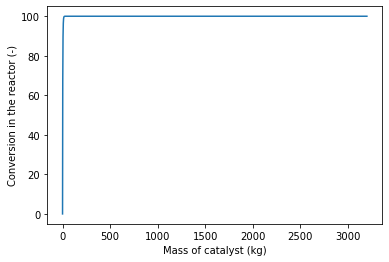

In [7]:
W = np.linspace(0,3200000,10000)
y = odeint(model, 0, W, (330,inlet_ch4_feed_molar_flowrate,inlet_CH4_frac, alpha_h2o, inlet_total_pressure))
for i,j in zip(y,W):
    print ("For the conversion {}, the mass of catalyst is {} g".format(i*100,j))
plt.plot(W/1000,y*100)
plt.xlabel("Mass of catalyst (kg)")
plt.ylabel("Conversion in the reactor (-)")

In [9]:
""" Amount of catalyst (g) for a particular conversion value
    W - Amount of catalyst for a given conversion value (g). A guess value should be given.
    X - Conversion required (fraction)
    T - Isothermal temperature of the reaction (C)
    F0 - Total flow rate of feed gas (mol.s-1)
    y0_CH4 - Mole fraction of methane in inlet air (fraction)
    RH - Relative humi dity in inlet air at 298.15K (%)"""

"""  ***WARNING*** in fsolve enter the initial value carefully, check the above mass - conversion values to get an estimate and 
                    enter the value close to it"""
def amount(W,X,T, F0, y0_CH4, alpha, inlet_total_pressure):
    t = [0,W]
    y1 = odeint(model, 0, t, (T,F0, y0_CH4, alpha, inlet_total_pressure))
    return X-y1[-1]
print ("Amount of catalyst required for {}% conversion of methane is {}g".format(0.999*100, float(fsolve(amount, 10000, args = (0.95,330,inlet_ch4_feed_molar_flowrate,inlet_CH4_frac, alpha_h2o, inlet_total_pressure)))))

Amount of catalyst required for 99.9% conversion of methane is 7098.099283393795g


In [14]:
""" Reinitialising and closing the simulation """
aspen_v2.Reinit()

com_error: (-2147023174, 'The RPC server is unavailable.', None, None)

In [15]:
aspen_v2.Close()

com_error: (-2147023174, 'The RPC server is unavailable.', None, None)